In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = "../app/data_pipeline"

features = pd.read_csv(f"{BASE}/features_train.csv")
print(features.shape)
features.head()

(266500, 48)


,target_date,warehouse_id,store_id,sku_id,region,cat_low,actual_order_qty,lag_1,lag_2,lag_4,...,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2023-02-27,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,NaN,NaN,NaN,...,1.0,3.375,0.0,102.375,0.250,76.00,0.0,0.101620,0.0,train
1,2023-03-06,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,NaN,NaN,...,1.0,5.350,0.0,88.525,2.725,76.00,0.0,0.172892,0.0,train
2,2023-03-13,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,1.0,6.150,0.0,82.825,2.625,76.00,0.0,0.198548,0.0,train
3,2023-03-20,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,1.0,9.100,0.0,62.175,2.625,76.00,0.0,0.234936,0.0,train
4,2023-03-27,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,0.0,...,1.0,11.100,0.0,48.450,2.625,73.25,0.0,0.300000,0.0,train


In [90]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matyplotlib -rf

Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [91]:
plt.rc('font', family='NanumBarunGothic')

# EDA
## 1. 타겟 분포 확인

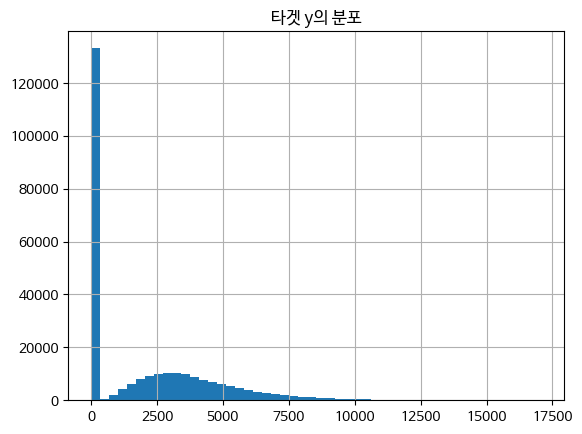

In [92]:
features["y"].hist(bins=50)
plt.title("타겟 y의 분포")
plt.show()

## 2. 기본 통계

In [93]:
features["y"].describe()

count    266500.000000
mean       2017.841463
std        2507.156599
min           0.000000
25%           0.000000
50%         613.000000
75%        3628.000000
max       17100.000000
Name: y, dtype: float64

median(50%) = 0, 75% = 89, max = 1098  
-> 거의 절반 이상의 주차가 판매 0. 나머지는 오른쪽으로 긴 꼬리가 있는 heavy right tail 분포  
: 0이 엄청 많고 일부 SKU가 크게 팔리는 구조. 전형적인 리테일/재고 데이터 모습  
: MAE 기준으로 보면 큰 수요가 있는 주차가 훨씬 더 영향을 많이 줌

## 3. 카테고리/sku별 판매량

In [94]:
features.columns.tolist()

['target_date',
 'warehouse_id',
 'store_id',
 'sku_id',
 'region',
 'cat_low',
 'actual_order_qty',
 'lag_1',
 'lag_2',
 'lag_4',
 'lag_8',
 'lag_12',
 'ma_4',
 'ma_8',
 'ma_12',
 'std_4',
 'std_12',
 'trend_1',
 'trend_4',
 'share_norm',
 'promo_flag',
 'promo_flag_prev',
 'year',
 'weekofyear',
 'month',
 'sin_week',
 'cos_week',
 'avg_temp_c',
 'cdd',
 'hdd',
 'precip_mm',
 'heat_wave',
 'cold_wave',
 'himart_sales_krw',
 'himart_sales_index',
 'holiday_index',
 'marketing_score',
 'seasonal_peak',
 'back_to_school',
 'avg_temp_c_ma4',
 'cdd_ma4',
 'hdd_ma4',
 'precip_mm_ma4',
 'himart_sales_index_ma4',
 'holiday_index_ma4',
 'marketing_score_ma4',
 'y',
 'split']

In [95]:
import pandas as pd
BASE = "../app/data_pipeline"
sku = pd.read_csv(f"{BASE}/sku_catalog.csv")

sku = sku[['sku_id', 'cat_low']] 

features_merged = features.merge(sku, on='sku_id', how='left')
features_merged.groupby("cat_low")["y"].sum().sort_values(ascending=False).head(20)


KeyError: 'cat_low'

어떤 카테고리/상품이 수요예측에서 중요한지.  

## 4. 날짜·주차별 패턴

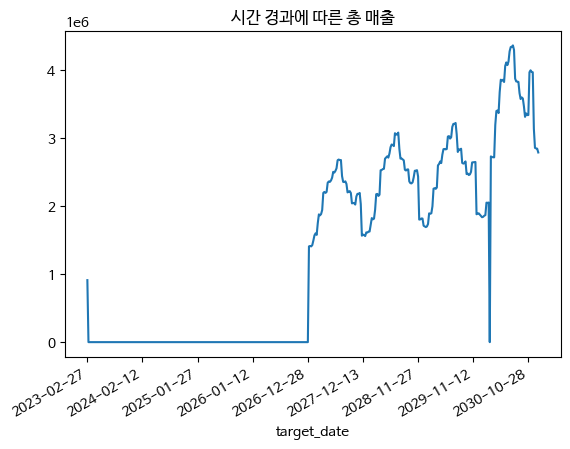

In [96]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
features.groupby("target_date")["y"].sum().plot(ax=ax)
plt.title("시간 경과에 따른 총 매출")

fig.autofmt_xdate() 
plt.show()


연도별로 계절 패턴이 보임  
-> 주간 수요예측 모델이 시즌성을 잘 잡아야함

## 5. 외부 요인 영향

In [97]:
cols = ["avg_temp_c", "holiday_index", "promo_flag"]  
features[cols + ["y"]].corr()


,avg_temp_c,holiday_index,promo_flag,y
avg_temp_c,1.000000,0.103465,-0.410028,-0.455634
holiday_index,0.103465,1.000000,-0.158362,-0.175779
promo_flag,-0.410028,-0.158362,1.000000,0.785897
y,-0.455634,-0.175779,0.785897,1.000000


프로모션, 기온은 수요에 큰 영향 줌. -> 피쳐로 유지  
완벽히 선형 관계는 아님. -> 트리계열 모델 사용해서 이런 패턴 잡아주기   
상관계수 낮아도 트리 기반 모델은 비선형 관계 잘 잡음

## 6.타깃 로그 변환 분포 확인

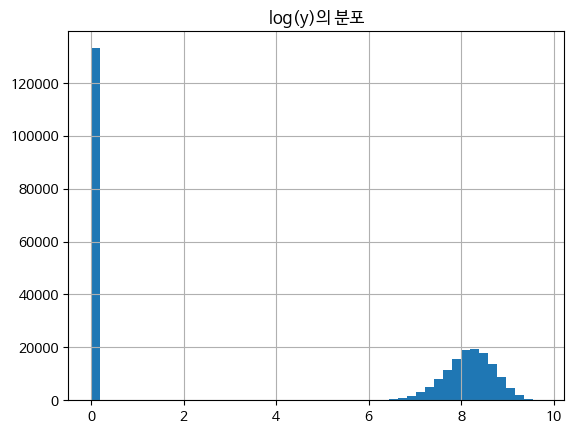

In [98]:
features["log_y"] = np.log1p(features["y"])
features["log_y"].hist(bins=50)
plt.title("log(y)의 분포")
plt.show()

0인 값이 많음 == 판매가 0인 주차가 많음.  
로그를 써서 큰 값 쪽 꼬리는 완화했지만 0값에 대해서는 따로 접근해야할수도 있음 

## 7. Lag Feature 상관분석  
Lag : 시차 변수. 과거 시점의 값을 그대로 가져와서 새로운 변수로 사용하는 것.

In [99]:
lag_cols = ["lag_1","lag_2","lag_4","lag_8","lag_12"]
features[lag_cols + ["y"]].corr()


,lag_1,lag_2,lag_4,lag_8,lag_12,y
lag_1,1.000000,0.981051,0.963330,0.929826,0.893149,0.981083
lag_2,0.981051,1.000000,0.971925,0.938385,0.902516,0.972002
lag_4,0.963330,0.971925,1.000000,0.957385,0.922257,0.955471
lag_8,0.929826,0.938385,0.957385,1.000000,0.957767,0.921590
lag_12,0.893149,0.902516,0.922257,0.957767,1.000000,0.883845
y,0.981083,0.972002,0.955471,0.921590,0.883845,1.000000


## 8. MA Feature 상관분석  
MA : 이동 평균. 일정 기간 동안의 평균값을 굴러가며 계산하는 것.

In [100]:
ma_cols = ["ma_4","ma_8","ma_12"]
features[ma_cols + ["y"]].corr()

,ma_4,ma_8,ma_12,y
ma_4,1.000000,0.993461,0.983654,0.976448
ma_8,0.993461,1.000000,0.995983,0.965298
ma_12,0.983654,0.995983,1.000000,0.953585
y,0.976448,0.965298,0.953585,1.000000


lag_* 와 y 상관이 0.93~0.98 수준, ma_*도 비슷하게 높음  
-> 바로 전/이전 주 수요가 현재 주 수요를 거의 직접적으로 설명.

## 9. 외부 요인 히트맵

In [101]:
!pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()


<Axes: >

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  func(*args, **kwargs)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


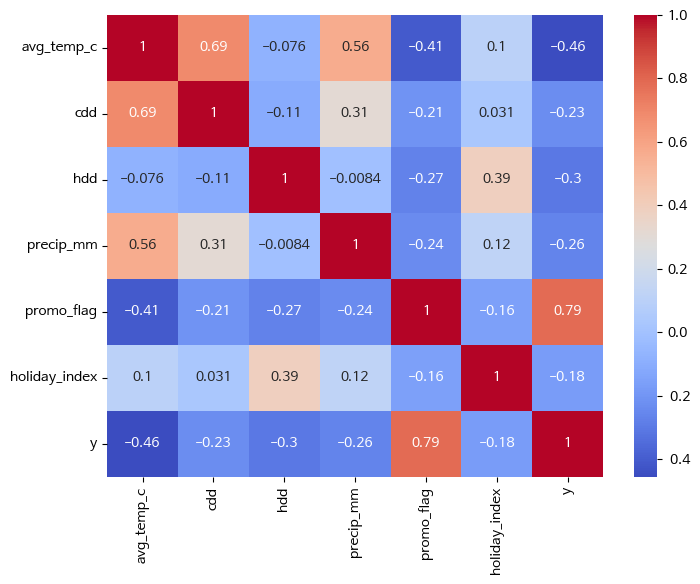

In [102]:
import seaborn as sns
plt.figure(figsize=(8,6))
cols = ["avg_temp_c","cdd","hdd","precip_mm","promo_flag","holiday_index"]
sns.heatmap(features[cols + ["y"]].corr(), annot=True, cmap="coolwarm")

## 10. SKU Sales profile

In [103]:
features.groupby("sku_id")["y"].sum().sort_values(ascending=False).head(20)

sku_id
MIX-BRV-STAND-5L-2024    16518260.0
DRY-SAM-GRN-20K-2024     13202979.0
AC-LG-STAND-18P-2024     13121768.0
AIR-LG-PURI-58-2024      13039439.0
MW-SAM-30L-2024          12921194.0
FR-SAM-4D-820L-2024      12850576.0
WM-LG-TOP-21K-2024       12597032.0
MW-LG-25L-2024           11967975.0
TV-LG-OLED-65-2024       11933860.0
OV-LG-70L-2024           11326145.0
FR-LG-OBJ-820L-2024      11017093.0
WM-SAM-GRN-24K-2024      10989967.0
DRY-LG-TROM-19K-2024     10861978.0
TV-SAM-QLED-65-2024      10558907.0
AIR-WNX-56-2024           9940602.0
AC-SAM-WF-18P-2024        9816775.0
DW-SAM-12P-2024           9590615.0
DW-LG-12P-2024            8759184.0
PHN-APL-IP15-128-2024     8745552.0
VAC-DYS-V11-2024          8590268.0
Name: y, dtype: float64

## 11. Feature Importance
데이터 일부만 이용해서 대략적인 feature 영향도 먼저 확인  
LightGBM로 미리 확인

In [104]:
from lightgbm import LGBMRegressor
train = features[features["split"] == "train"].copy()

y = train["y"]

ignore = [
    "warehouse_id", "store_id", "sku_id", "region",
    "target_date", "split", "y",
]

X = train.drop(columns=ignore, errors="ignore")

numeric_cols = X.select_dtypes(include=["number", "bool"]).columns
X = X[numeric_cols]

from lightgbm import LGBMRegressor

model = LGBMRegressor(random_state=42)
model.fit(X, y)

importances = (
    pd.Series(model.feature_importances_, index=X.columns)
      .sort_values(ascending=False)
)
importances.head(20)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.225911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5059
[LightGBM] [Info] Number of data points in the train set: 266500, number of used features: 41
[LightGBM] [Info] Start training from score 2017.841463


actual_order_qty    1210
trend_4              286
trend_1              249
std_4                198
share_norm           174
std_12               172
lag_4                139
lag_1                126
ma_4                  68
lag_12                67
weekofyear            63
cos_week              58
lag_2                 54
lag_8                 48
ma_12                 33
sin_week              27
ma_8                  21
year                   5
month                  2
promo_flag_prev        0
dtype: int32

## 12. SKU별 수요 패턴 시각화
SKU마다 수요 패턴이 크게 다를 수 있으므로(시즌형, 안정형, 변동 폭주형 등),     
샘플 SKU를 몇 개 골라서 수요 변화 추이를 확인   
-> SKU별 이질성을 얼마나 잘 학습해야 하는지 판단하는 데 도움

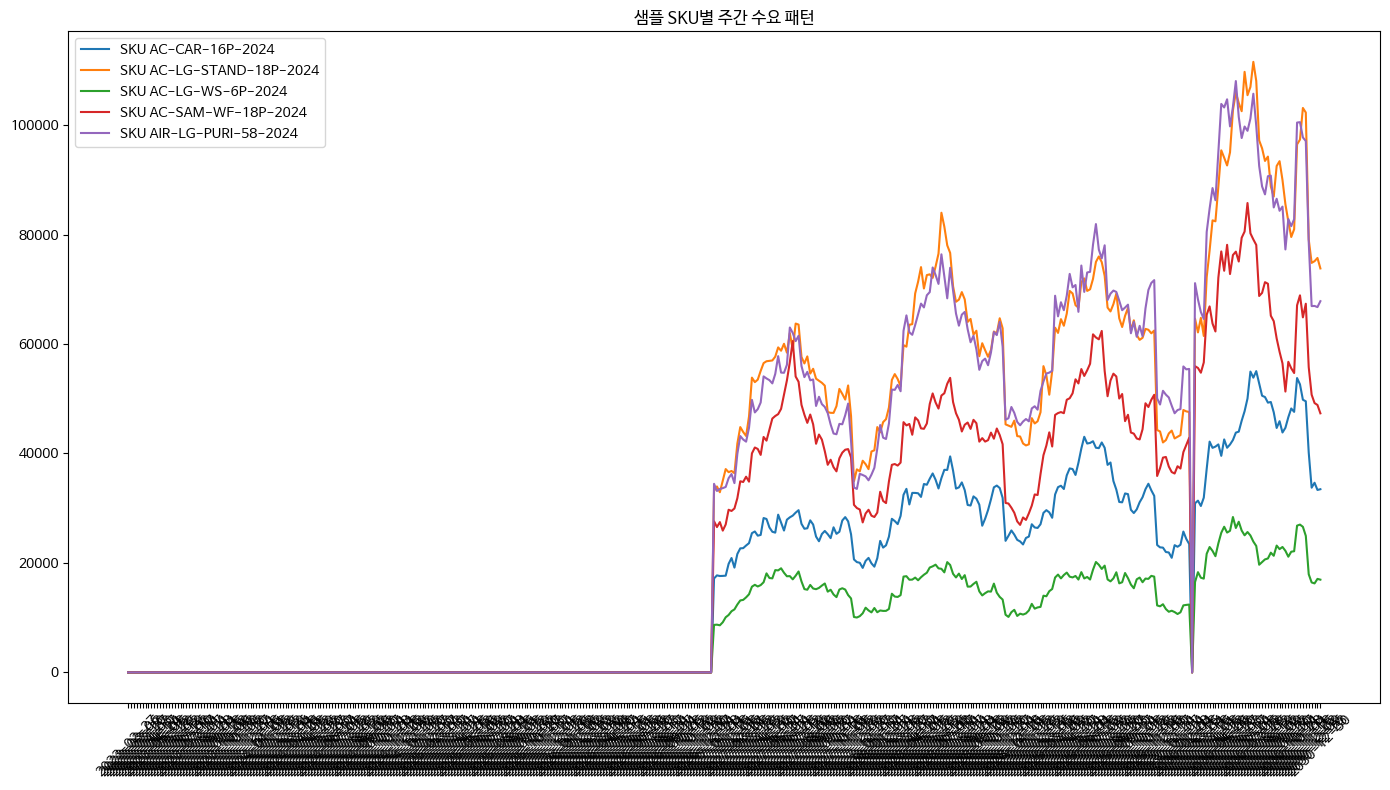

In [105]:
# 임의 SKU 5개 샘플 추출
sample_skus = features["sku_id"].dropna().unique()[:5]

plt.figure(figsize=(14, 8))
for sku in sample_skus:
    subset = features[(features["sku_id"] == sku) & (features["split"] == "train")]

    subset_group = subset.groupby("target_date")["y"].sum()

    plt.plot(subset_group.index, subset_group.values, label=f"SKU {sku}")

plt.title("샘플 SKU별 주간 수요 패턴")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 13. Lag 피처 vs Target Cross-Correlation
lag 값이 몇 주까지 유효한지 확인 -> lag 범위 확장/축소 근거 제공

In [106]:
!pip install statsmodels


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


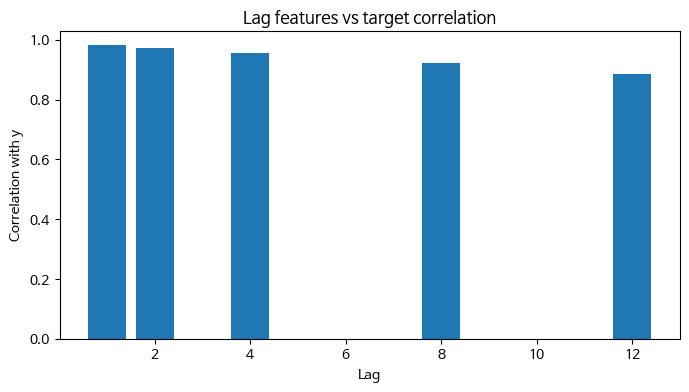

In [107]:
from statsmodels.tsa.stattools import ccf

train = features[features["split"] == "train"].copy()

lags = [1, 2, 4, 8, 12]

corrs = []
for lag in lags:
    corr = train["y"].corr(train[f"lag_{lag}"])
    corrs.append(corr)

plt.figure(figsize=(8, 4))
plt.bar(lags, corrs)
plt.xlabel("Lag")
plt.ylabel("Correlation with y")
plt.title("Lag features vs target correlation")
plt.show()


## 14. 프로모션/휴일 효과 Boxplot
프로모션·휴일 등의 외부 요인이 실제로 수요량을 변화시키는지 유의한 근거 확보

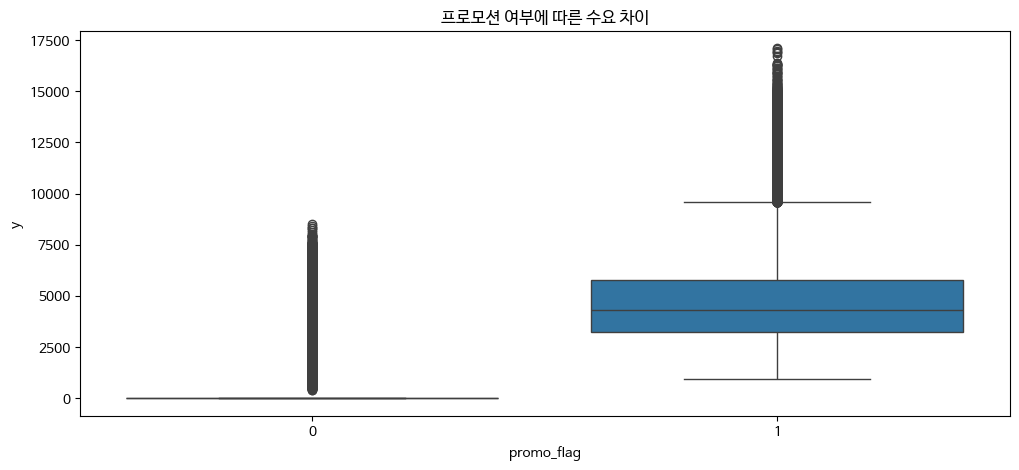

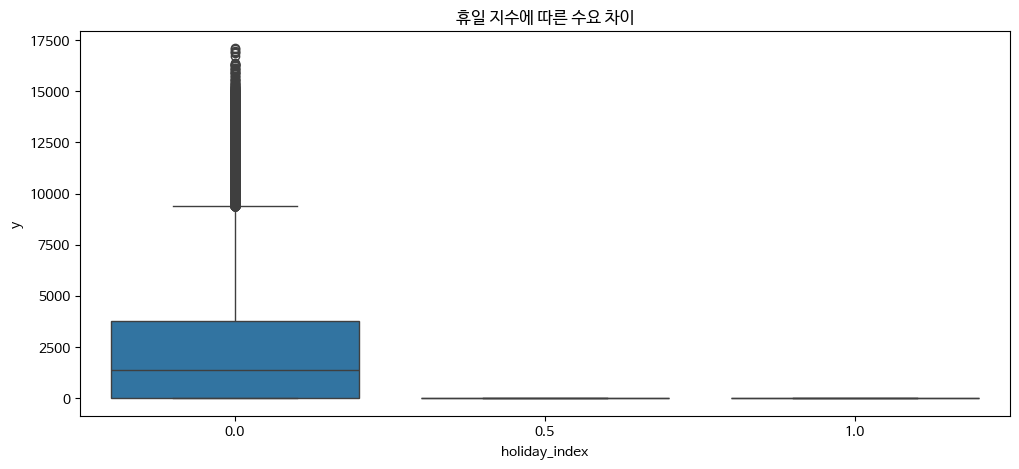

In [108]:
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.boxplot(x="promo_flag", y="y", data=train)
plt.title("프로모션 여부에 따른 수요 차이")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x="holiday_index", y="y", data=train)
plt.title("휴일 지수에 따른 수요 차이")
plt.show()


## 15. 결측치 히트맵
외부요인/lag/MA 피처 중 결측치 비율이 높은 항목이 있는지 확인

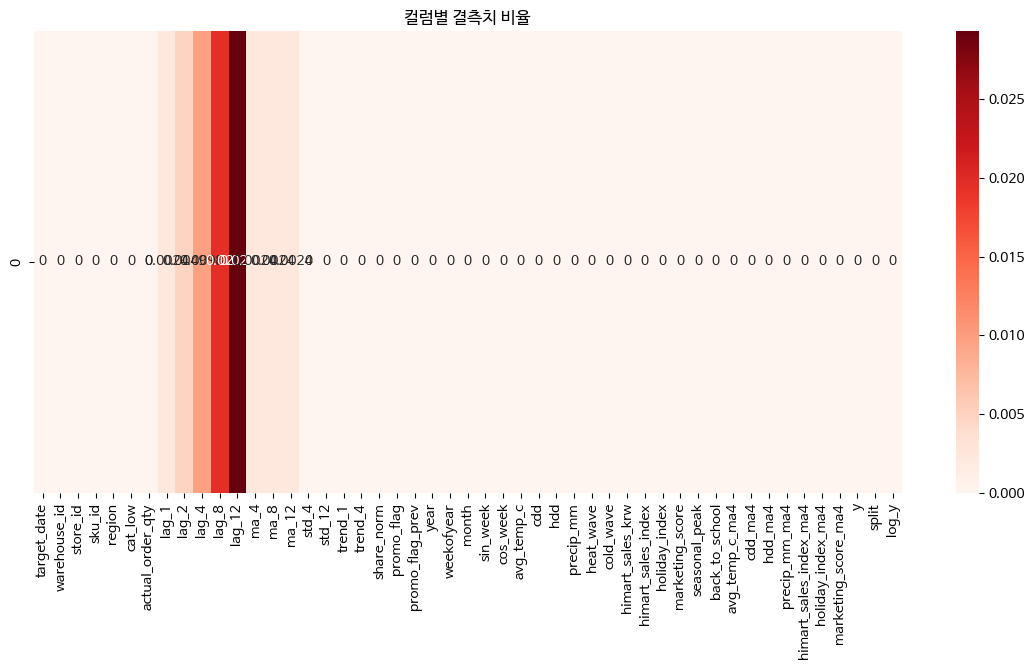

In [109]:
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.heatmap(features.isnull().mean().to_frame().T, cmap="Reds", annot=True)
plt.title("컬럼별 결측치 비율")
plt.show()


라그/이동평균은 초기 몇 주는 값이 없어서 NaN 이 나옴.  
나머지 컬럼은 원래부터 결측이 거의 없거나 코드 상에서 이미 fillna(0) 등으로 처리한 뒤라서 결측 비율이 0으로 나옴

## 16. 카테고리별 평균 수요 비교
카테고리별 기본 수요 수준 차이를 확인 -> target encoding/one-hot 전략 근거

In [110]:
from pathlib import Path
import pandas as pd

BASE = Path("../app/data_pipeline").resolve()

print(">>> LOADING FROM:", BASE / "features_all.csv")
df = pd.read_csv(BASE / "features_all.csv")

print(df.shape)
df.head()


>>> LOADING FROM: C:\Users\chosw\ORDER101_AI\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\features_all.csv
(300300, 48)


,target_date,warehouse_id,store_id,sku_id,region,cat_low,actual_order_qty,lag_1,lag_2,lag_4,...,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2023-02-27,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,NaN,NaN,NaN,...,1.0,3.375,0.0,102.375,0.250,76.00,0.0,0.101620,0.0,train
1,2023-03-06,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,NaN,NaN,...,1.0,5.350,0.0,88.525,2.725,76.00,0.0,0.172892,0.0,train
2,2023-03-13,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,1.0,6.150,0.0,82.825,2.625,76.00,0.0,0.198548,0.0,train
3,2023-03-20,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,1.0,9.100,0.0,62.175,2.625,76.00,0.0,0.234936,0.0,train
4,2023-03-27,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,0.0,...,1.0,11.100,0.0,48.450,2.625,73.25,0.0,0.300000,0.0,train


In [111]:
# 전체 데이터
features = df.copy()

# 학습용(숫자 전용) 데이터
train = features[features["split"] == "train"].copy()
numeric_cols = train.select_dtypes(include=["number", "bool"]).columns
train_numeric = train[numeric_cols]


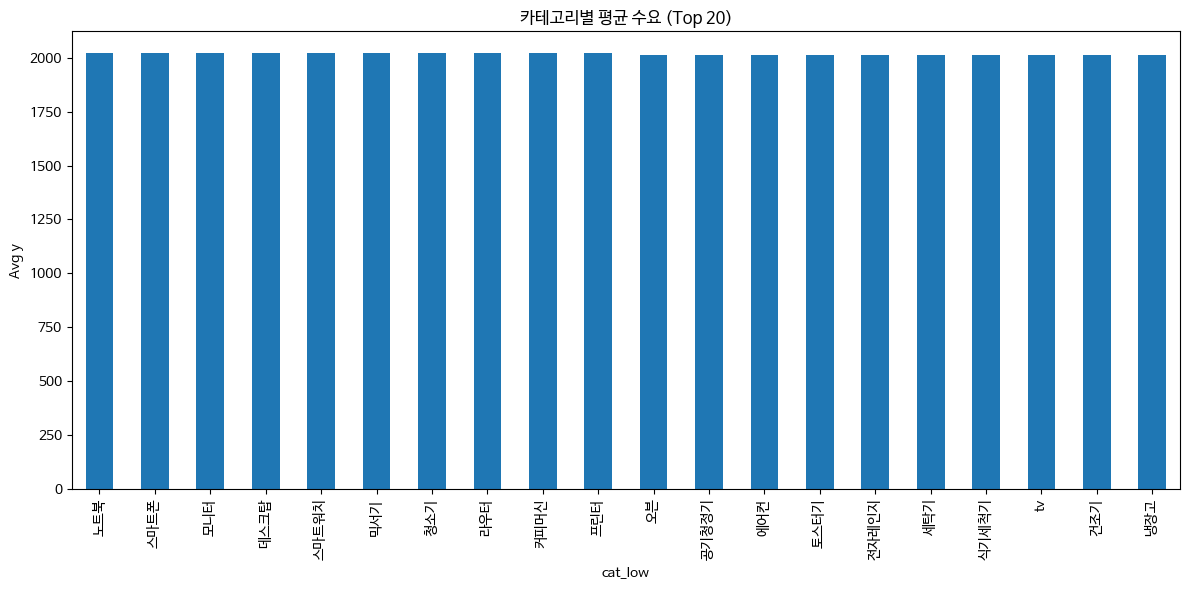

In [112]:
train_cat = features[features["split"] == "train"].copy()

cat_mean = (
    train_cat
      .groupby("cat_low")["y"]
      .mean()
      .sort_values(ascending=False)
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
cat_mean.head(20).plot(kind="bar")
plt.title("카테고리별 평균 수요 (Top 20)")
plt.ylabel("Avg y")
plt.tight_layout()
plt.show()


In [113]:
features.columns


Index(['target_date', 'warehouse_id', 'store_id', 'sku_id', 'region',
       'cat_low', 'actual_order_qty', 'lag_1', 'lag_2', 'lag_4', 'lag_8',
       'lag_12', 'ma_4', 'ma_8', 'ma_12', 'std_4', 'std_12', 'trend_1',
       'trend_4', 'share_norm', 'promo_flag', 'promo_flag_prev', 'year',
       'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd',
       'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw',
       'himart_sales_index', 'holiday_index', 'marketing_score',
       'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4',
       'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4',
       'holiday_index_ma4', 'marketing_score_ma4', 'y', 'split'],
      dtype='object')

In [114]:
BASE = "../app/data_pipeline"

train = pd.read_csv(f"{BASE}/features_train.csv")
test  = pd.read_csv(f"{BASE}/features_test.csv")

train["split"] = "train"
test["split"]  = "test"

features = pd.concat([train, test], ignore_index=True)

print("train:", train.shape, "test:", test.shape, "all:", features.shape)
features.head()

train: (266500, 48) test: (33800, 48) all: (300300, 48)


,target_date,warehouse_id,store_id,sku_id,region,cat_low,actual_order_qty,lag_1,lag_2,lag_4,...,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2023-02-27,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,NaN,NaN,NaN,...,1.0,3.375,0.0,102.375,0.250,76.00,0.0,0.101620,0.0,train
1,2023-03-06,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,NaN,NaN,...,1.0,5.350,0.0,88.525,2.725,76.00,0.0,0.172892,0.0,train
2,2023-03-13,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,1.0,6.150,0.0,82.825,2.625,76.00,0.0,0.198548,0.0,train
3,2023-03-20,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,1.0,9.100,0.0,62.175,2.625,76.00,0.0,0.234936,0.0,train
4,2023-03-27,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,0.0,...,1.0,11.100,0.0,48.450,2.625,73.25,0.0,0.300000,0.0,train


In [115]:
train = features[features["split"] == "train"].copy()
test  = features[features["split"] == "test"].copy()

ignore = ["warehouse_id","store_id","sku_id","region","target_date","split","y"]
X_train = train.drop(columns=ignore, errors="ignore")
X_test  = test.drop(columns=ignore, errors="ignore")

num_cols = X_train.select_dtypes(include=["number","bool"]).columns
X_train = X_train[num_cols]
X_test  = X_test[num_cols]

y_train = train["y"]
y_test  = test["y"]


In [116]:
print("train:", train.shape, "test:", test.shape, "all:", features.shape)

train: (266500, 48) test: (33800, 48) all: (300300, 48)


# Baseline Modeling
## 1. Baseline MAE

In [117]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

train = features[features["split"] == "train"].copy()
test  = features[features["split"] == "test"].copy()

ignore = [
    "warehouse_id", "store_id", "sku_id", "region",
    "target_date", "split", "y",
]

X_train = train.drop(columns=ignore, errors="ignore")
X_test  = test.drop(columns=ignore, errors="ignore")

num_cols = X_train.select_dtypes(include=["number", "bool"]).columns
X_train = X_train[num_cols]
X_test  = X_test[num_cols]

y_train = train["y"].astype(float)
y_test  = test["y"].astype(float)

print("X_train:", X_train.shape, "X_test:", X_test.shape)

model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(X_train, y_train)

pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
print("Baseline MAE:", mae)


X_train: (266500, 40) X_test: (33800, 40)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4804
[LightGBM] [Info] Number of data points in the train set: 266500, number of used features: 40
[LightGBM] [Info] Start training from score 2017.841463
Baseline MAE: 333.8493598631523


## 2. importances

In [118]:
importances = (
    pd.Series(model.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
)
importances.head(30)


actual_order_qty      2585
trend_1               2193
lag_1                 1828
trend_4               1576
std_4                 1230
share_norm             951
std_12                 853
lag_4                  670
ma_4                   585
lag_2                  479
lag_12                 461
lag_8                  347
weekofyear             344
cos_week               259
ma_12                  230
sin_week               170
ma_8                   152
month                   49
year                    35
promo_flag               2
promo_flag_prev          1
avg_temp_c               0
cdd                      0
hdd                      0
precip_mm                0
heat_wave                0
cold_wave                0
himart_sales_krw         0
himart_sales_index       0
holiday_index            0
dtype: int32

## 3. log 변환 모델

In [119]:
y_train_log = np.log1p(y_train)

model_log = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model_log.fit(X_train, y_train_log)

pred_log = model_log.predict(X_test)
pred_log_to_y = np.expm1(pred_log)

mae_log = mean_absolute_error(y_test, pred_log_to_y)
print("MAE (log target):", mae_log)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4804
[LightGBM] [Info] Number of data points in the train set: 266500, number of used features: 40
[LightGBM] [Info] Start training from score 4.088382
MAE (log target): 320.21876510808096
